In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as spio

# Bayesian linear regression

In this exercise session we consider the supervised regression problem of finding a function $f(x)$ that describes the relationship between a scalar input $x$ and a scalar output $y$:

$$
y = f(x) + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, \beta^{-1}).
$$

We model this with a Bayesian linear regression model

$$
f(x) = \boldsymbol{\phi}(x)^{\mathsf{T}} \mathbf{w}, \qquad \mathbf{w} \sim \mathcal{N}(\boldsymbol{\mu}_0, \mathbf{S}_0),
$$

where $\boldsymbol{\phi}(x)$ is a vector of the input features.
Note that we used the notation $\mathbf{x}$ for the input features in the lecture.
We changed this notation to $\boldsymbol{\phi}(x)$ here in order to not mix it up with the scalar input $x$.

The Bayesian linear regression model is then given by

$$
\begin{aligned}
p(\mathbf{y} \,|\, \mathbf{w}) &= \mathcal{N}(\mathbf{y}; \boldsymbol{\Phi}\mathbf{w}, \beta^{-1}\mathbf{I}_N) \qquad && \text{(likelihood)}, \\
p(\mathbf{w}) &= \mathcal{N}(\mathbf{w}; \mathbf{m}_0, \mathbf{S}_0) \qquad && \text{(prior)},
\end{aligned}
$$

where

$$
\boldsymbol{\Phi} = \begin{bmatrix} \boldsymbol{\phi}(x_1)^{\mathsf{T}} \\ \vdots \\ \boldsymbol{\phi}(x_N)^{\mathsf{T}} \end{bmatrix}
\qquad \text{and} \qquad
\mathbf{y} = \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix}.
$$

Given a set of training data of inputs and outputs $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$, we are interested in finding the posterior of the weights $p(\mathbf{w} \,|\, \mathbf{y})$ and also the predictive distribution $p(f(x_{\star}) \,|\, \mathbf{y})$ of unseen input $x_{\star}$.
For further information about the Bayesian linear regression model see Lecture 3 and/or Christopher Bishop's book ["Pattern recognition and machine learning"](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/).


## Exercise 3.1: Understanding the code

Download the files <a href="https://uni-tuebingen.de/fileadmin/Uni_Tuebingen/Fakultaeten/MatNat/Fachbereiche/Informatik/Lehrstuehle/MethMaschLern/Probabilistic_ML/Notebook_Vorlesung_7___9/lindata.mat" download="lindata.mat">`lindata.mat`</a> and <a href="https://uni-tuebingen.de/fileadmin/Uni_Tuebingen/Fakultaeten/MatNat/Fachbereiche/Informatik/Lehrstuehle/MethMaschLern/Probabilistic_ML/Notebook_Vorlesung_7___9/nlindata.mat" download="nlindata.mat">`nlindata.mat`</a> and save them to the folder of this notebook.
These datasets are borrowed from Philipp Hennig's course ["Probabilistic machine learning"](https://uni-tuebingen.de/en/180804), given at the University of Tübingen.

The following code cell loads inputs, outputs, and precision parameter from `lindata.mat` and plots the feature vector

$$
\boldsymbol{\phi}(x)^{\mathsf{T}} = [1, x].
$$

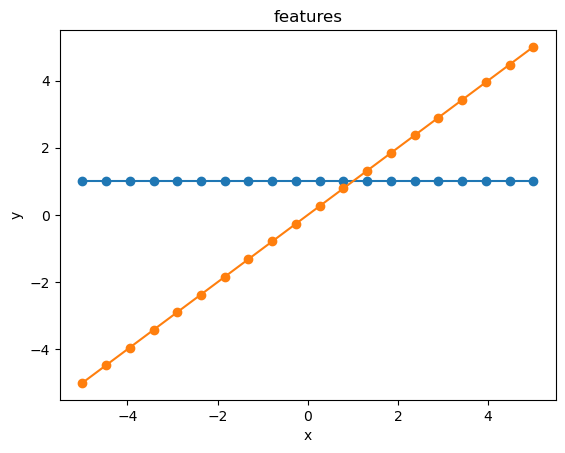

In [2]:
# Load data from disk
# File should be in the same folder as the Jupyter notebook,
# otherwise you have to adjust the path
data = spio.loadmat("lindata.mat")
x = data["X"].flatten() # inputs
y = data["Y"].flatten() # outputs
beta = float(data["sigma"])**(-2) # measurement noise precision
N = x.size

# Define the feature vector
def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(2))

# Plot the features
plt.plot(x, Phi(x), '-o')
plt.title('features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Analyzing the data 

In [3]:
print(f'x: {x}')
print(f'Phi x: {Phi(x)}')
print(f'y: {y}')
print(f'beta: {beta}')

x: [-5.         -4.47368421 -3.94736842 -3.42105263 -2.89473684 -2.36842105
 -1.84210526 -1.31578947 -0.78947368 -0.26315789  0.26315789  0.78947368
  1.31578947  1.84210526  2.36842105  2.89473684  3.42105263  3.94736842
  4.47368421  5.        ]
Phi x: [[ 1.         -5.        ]
 [ 1.         -4.47368421]
 [ 1.         -3.94736842]
 [ 1.         -3.42105263]
 [ 1.         -2.89473684]
 [ 1.         -2.36842105]
 [ 1.         -1.84210526]
 [ 1.         -1.31578947]
 [ 1.         -0.78947368]
 [ 1.         -0.26315789]
 [ 1.          0.26315789]
 [ 1.          0.78947368]
 [ 1.          1.31578947]
 [ 1.          1.84210526]
 [ 1.          2.36842105]
 [ 1.          2.89473684]
 [ 1.          3.42105263]
 [ 1.          3.94736842]
 [ 1.          4.47368421]
 [ 1.          5.        ]]
y: [ -3.9555788  -10.20466854  -4.07732766  -3.80423523  -5.54641695
  -6.49758779   2.50363387  -4.84736199   0.21816925   1.52647205
  -0.59432226   0.92732946   5.04358645   1.77229585   5.75286021
   

We then compute the posterior distribution of the weights $\mathbf{w}$ of a Bayesian linear regression model using these features.

In [4]:
# Define the prior on the weights
# p(w) = N(w; m0, S0)
D = Phi(0).size  # number of features
m0 = np.zeros(D)
S0 = 10*np.eye(D) / D

# Compute the posterior distribution of the Bayesian linear regression model
# p(w | y) = N(w; mN, SN)
SN = np.linalg.inv(np.linalg.inv(S0) + beta * Phi(x).T @ Phi(x)) # See exercise sheet 2
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * Phi(x).T @ y)

### Analyzing the data

In [5]:
print(f'D: {D}')
print(f'm0: {m0}')
print(f'S0: {S0}')
print(f'SN: {SN}')
print(f'mN: {mN}')

D: 2
m0: [0. 0.]
S0: [[5. 0.]
 [0. 5.]]
SN: [[0.11002445 0.        ]
 [0.         0.01218452]]
mN: [0.0747528  1.34430857]


We visualize the posterior distribution by plotting the functions $f$ corresponding to different samples of $\mathbf{w}$.

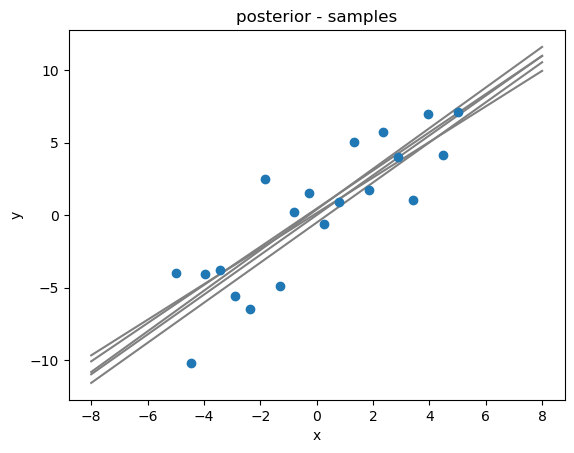

In [6]:
# Generate grid of new inputs x* for plotting
n = 100  # number of grid-points
xs = np.linspace(-8, 8, n)

# Visualize the posterior p(w | y) = N(w; mN, SN)
# For samples of w, f(x) = phi(x)^T w is evaluated at inputs xs
# Draw samples of w from the posterior
samples = 5
seed = 100
ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Compute corresponding values f(x*)
fs = Phi(xs) @ ws.T

# Plot the samples
plt.plot(xs, fs, 'gray') # samples
plt.scatter(x, y, zorder=3)
plt.title('posterior - samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Next we plot samples from and credibility regions of the predictive distribution.

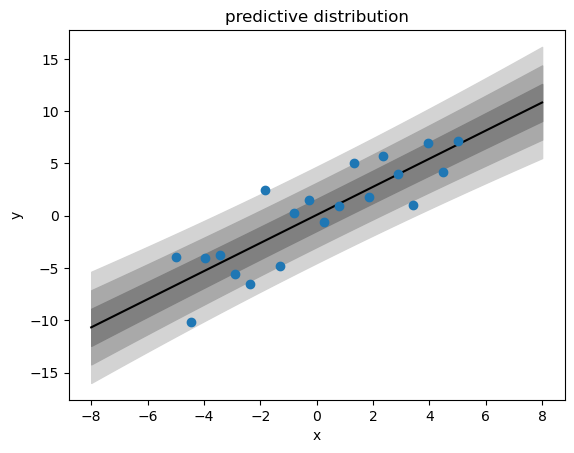

In [7]:
# Compute the predictive distribution of the outputs y*
# p(y* | y) = N(y*; m*, S*)
mstar = Phi(xs) @ mN
Sstar = Phi(xs) @ SN @ Phi(xs).T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred= np.sqrt(np.diag(Sstar))

# Plot credibility regions
plt.plot(xs, mstar, 'black') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray')
plt.scatter(x, y, zorder=3)
plt.title('predictive distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### (a)

Go through the code and make sure that you can map the code to the model and regression method explained in Lecture 3.
Also run the code.
Make sure you understand the figures.

### (b)

Reduce the training data to only the first 5 data points in the training data.
What impact does this have on the predictive distribution?

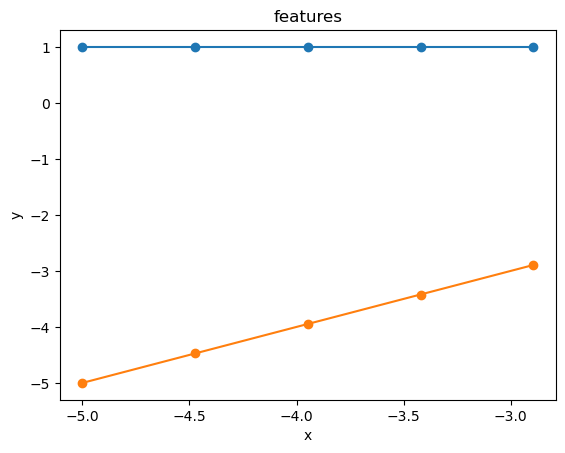

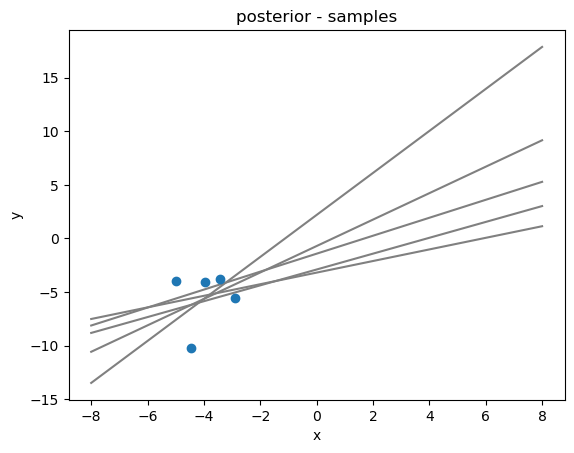

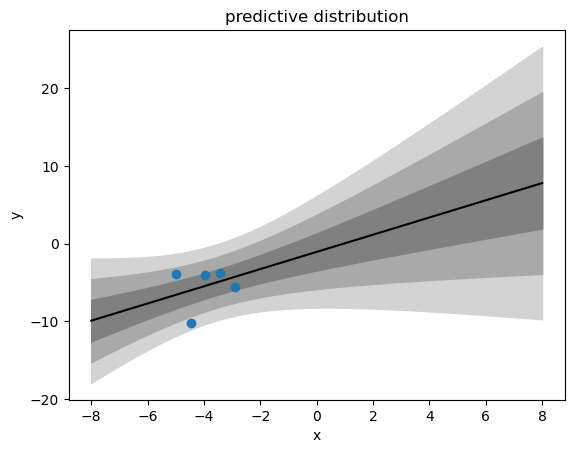

In [8]:
# Load data from disk
# File should be in the same folder as the Jupyter notebook,
# otherwise you have to adjust the path
data = spio.loadmat("lindata.mat")
x = data["X"].flatten()[0:5] # inputs
y = data["Y"].flatten()[0:5] # outputs
beta = float(data["sigma"])**(-2) # measurement noise precision
N = x.size

# Define the feature vector
def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(2))

# Plot the features
plt.plot(x, Phi(x), '-o')
plt.title('features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Define the prior on the weights
# p(w) = N(w; m0, S0)
D = Phi(0).size  # number of features
m0 = np.zeros(D)
S0 = 10*np.eye(D) / D

# Compute the posterior distribution of the Bayesian linear regression model
# p(w | y) = N(w; mN, SN)
SN = np.linalg.inv(np.linalg.inv(S0) + beta * Phi(x).T @ Phi(x)) # See exercise sheet 2
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * Phi(x).T @ y)

# Generate grid of new inputs x* for plotting
n = 100  # number of grid-points
xs = np.linspace(-8, 8, n)

# Visualize the posterior p(w | y) = N(w; mN, SN)
# For samples of w, f(x) = phi(x)^T w is evaluated at inputs xs
# Draw samples of w from the posterior
samples = 5
seed = 100
ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Compute corresponding values f(x*)
fs = Phi(xs) @ ws.T

# Plot the samples
plt.plot(xs, fs, 'gray') # samples
plt.scatter(x, y, zorder=3)
plt.title('posterior - samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Compute the predictive distribution of the outputs y*
# p(y* | y) = N(y*; m*, S*)
mstar = Phi(xs) @ mN
Sstar = Phi(xs) @ SN @ Phi(xs).T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred= np.sqrt(np.diag(Sstar))

# Plot credibility regions
plt.plot(xs, mstar, 'black') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray')
plt.scatter(x, y, zorder=3)
plt.title('predictive distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Answer

Much more uncertainty, especially for values of x that are not included in, and are far away from, the training data.

## Exercise 3.2: Feature vectors

### (a)

Load `nlindata.mat` instead of `lindata.mat` and run the code for this data.
Use all data, not only the first five data points as in Exercise 3.1 (b).
Do you think the model performs well on this data?

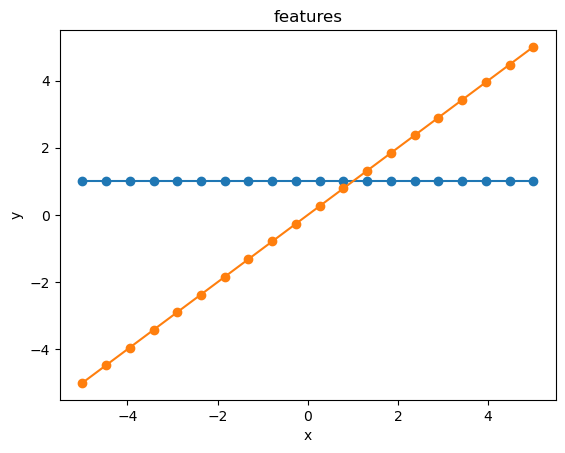

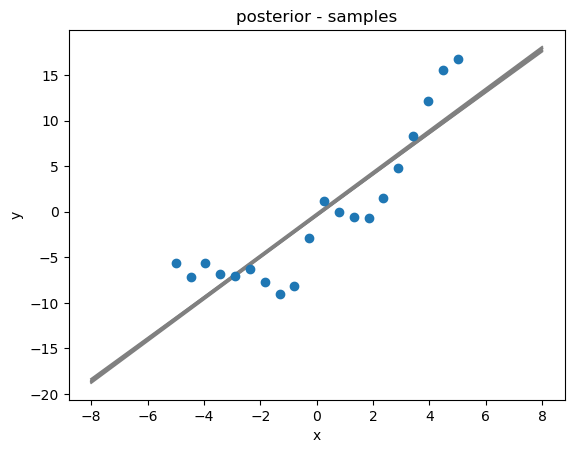

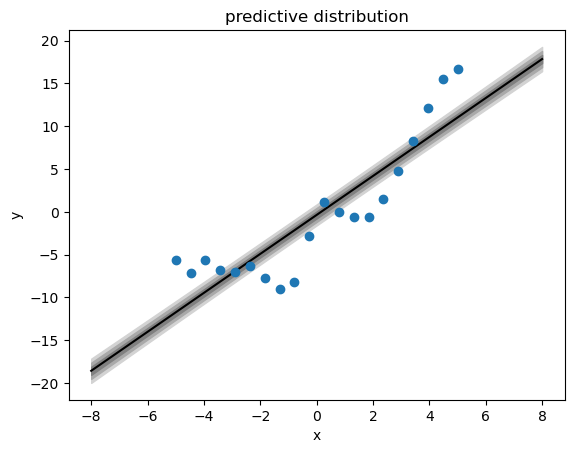

In [9]:
data = spio.loadmat("nlindata.mat")
x = data["X"].flatten() 
y = data["Y"].flatten() 
beta = float(data["sigma"])**(-2) 
N = x.size

def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(2))


plt.plot(x, Phi(x), '-o')
plt.title('features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


D = Phi(0).size  
m0 = np.zeros(D)
S0 = 10*np.eye(D) / D


SN = np.linalg.inv(np.linalg.inv(S0) + beta * Phi(x).T @ Phi(x))
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * Phi(x).T @ y)


n = 100  
xs = np.linspace(-8, 8, n)


samples = 5
seed = 100
ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)


fs = Phi(xs) @ ws.T


plt.plot(xs, fs, 'gray') 
plt.scatter(x, y, zorder=3)
plt.title('posterior - samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

mstar = Phi(xs) @ mN
Sstar = Phi(xs) @ SN @ Phi(xs).T + beta**(-1) * np.eye(n)


stdpred= np.sqrt(np.diag(Sstar))


plt.plot(xs, mstar, 'black') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray')
plt.scatter(x, y, zorder=3)
plt.title('predictive distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Answer

It seems like the model might be better with a nonlinear features

### (b)

In order to improve the performance, consider instead a feature vector with an additional quadratic term

$$
\boldsymbol{\phi}(x)^{\mathsf{T}} = [1, x, x^2].
$$

Change the code accordingly and run it.

*Hint:* Only a very minor modification in the code is required to accommodate for this change.

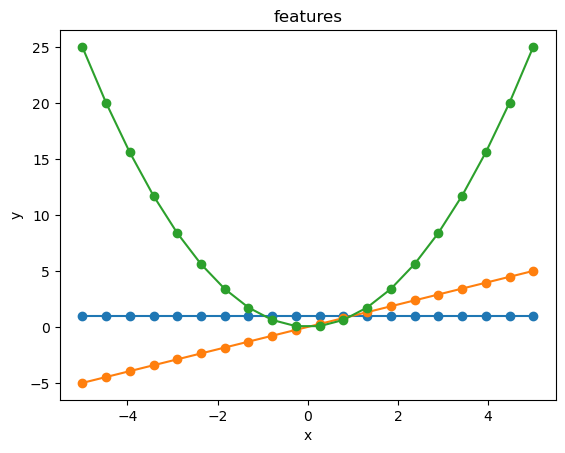

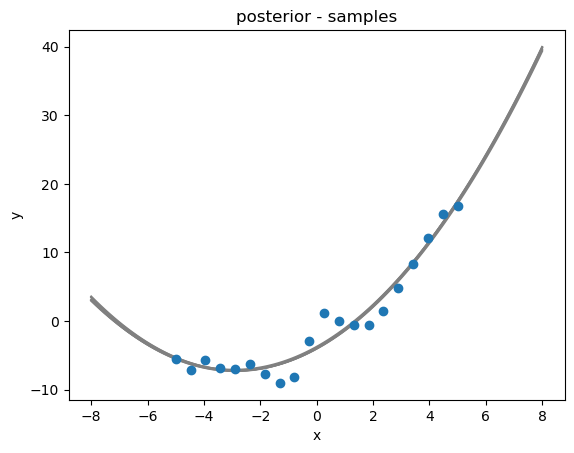

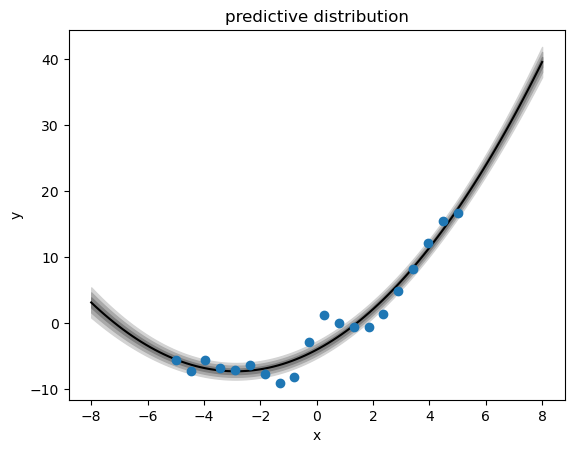

In [10]:
def Phi(a):  # Phi(a) = [1, a]
    return np.power(np.reshape(a, (-1, 1)), range(3))


plt.plot(x, Phi(x), '-o')
plt.title('features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

D = Phi(0).size  
m0 = np.zeros(D)
S0 = 10*np.eye(D) / D

SN = np.linalg.inv(np.linalg.inv(S0) + beta * Phi(x).T @ Phi(x))
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * Phi(x).T @ y)

n = 100  
xs = np.linspace(-8, 8, n)

samples = 5
seed = 100
ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

fs = Phi(xs) @ ws.T

plt.plot(xs, fs, 'gray') 
plt.scatter(x, y, zorder=3)
plt.title('posterior - samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

mstar = Phi(xs) @ mN
Sstar = Phi(xs) @ SN @ Phi(xs).T + beta**(-1) * np.eye(n)

stdpred= np.sqrt(np.diag(Sstar))

plt.plot(xs, mstar, 'black') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray')
plt.scatter(x, y, zorder=3)
plt.title('predictive distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### (c)

Use step functions

$$
h(x) = \begin{cases}
1, \qquad x \geq 0,\\
0, \qquad x < 0,
\end{cases}
$$

as features and change the code accordingly.
Place in total 9 of these features with two steps apart between $x = -8$ and $x = 8$.
The feature vector is then

$$
\boldsymbol{\phi}(x)^{\mathsf{T}} = [h(x-8), h(x - 6), \ldots, h(x + 8)].
$$

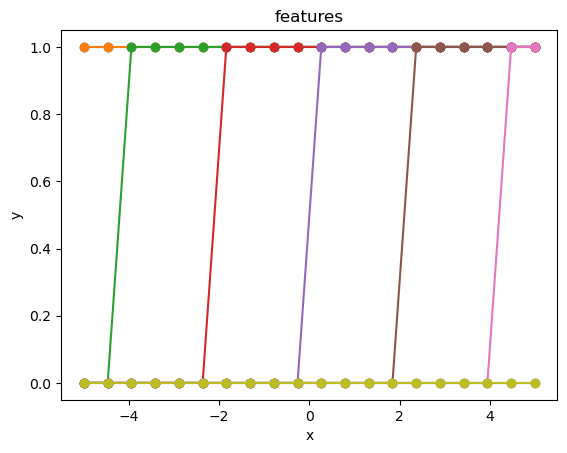

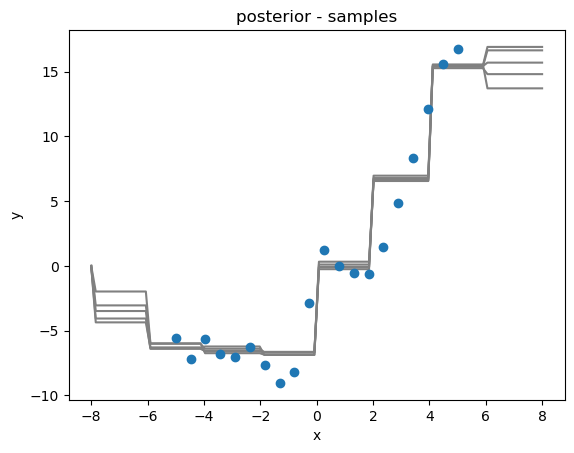

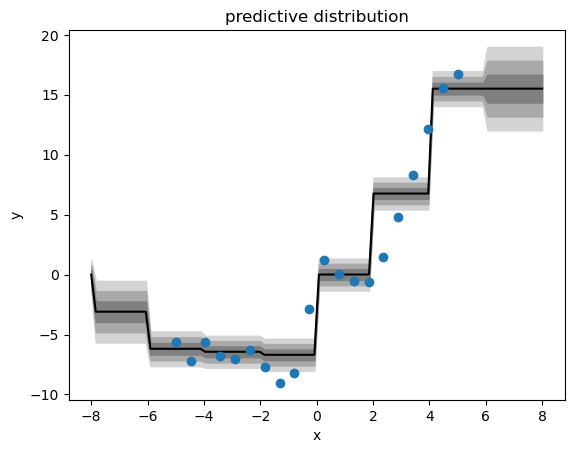

In [12]:
data = spio.loadmat("nlindata.mat")
x = data["X"].flatten() 
y = data["Y"].flatten() 
beta = float(data["sigma"])**(-2) 
N = x.size

def Phi(x):  # Phi(x) = [1, x]
    return (np.reshape(x, (-1, 1)) > np.linspace(-8,8,9))


plt.plot(x, Phi(x), '-o')
plt.title('features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


D = Phi(0).size  
m0 = np.zeros(D)
S0 = 10*np.eye(D) / D


SN = np.linalg.inv(np.linalg.inv(S0) + beta * Phi(x).T @ Phi(x))
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * Phi(x).T @ y)


n = 100  
xs = np.linspace(-8, 8, n)


samples = 5
seed = 100
ws = stats.multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)


fs = Phi(xs) @ ws.T


plt.plot(xs, fs, 'gray') 
plt.scatter(x, y, zorder=3)
plt.title('posterior - samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

mstar = Phi(xs) @ mN
Sstar = Phi(xs) @ SN @ Phi(xs).T + beta**(-1) * np.eye(n)


stdpred= np.sqrt(np.diag(Sstar))


plt.plot(xs, mstar, 'black') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray')
plt.scatter(x, y, zorder=3)
plt.title('predictive distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()